# Хiд виконання роботи

1. ! ! ! Розiбратися з прикладом створення класу, який реалiзує багатошарову нейронну мережу прямого розповсюдження за допомогою бiблiотеки TensorFlow, та реалiзацiєю алгоритму зворотного розповсюдження помилки (back propagation)  [посилання](https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/ch12/ch12.ipynb)

2. Завантажити простий набiр зображень типу MNIST згiдно з варiантом.
3. Виконати пiдготовку даних для навчання - за необхiдностi, залежно вiд вхiдного набору. Наприклад, нормалiзувати данi тощо.

4. За необхiдностi розбити данi на навчальну i перевiрочну множини у спiввiдношеннi 80%: 20%. Звернути увагу, що завантаженi данi можуть бутивже розбитими на навчальну i перевiрочну множини.

5. Побудувати базову мережу прямого розповсюдження сигналу з єдиним вихiдним шаром softmax. Для створення моделi реалiзувати клас, використовуючи, наприклад, tf.Module або object (див. посилання на приклад вище). Ваги iнiцiалiзувати невеликими випадковими значеннями, якi нормально розподiленi з нульовим середнiм та малою дисперсiєю.

6. Реалiзувати алгоритм зворотного розповсюдження помилки (back propagation) (див. посилання на приклад вище).

7. Функцiєю втрат задати регуляризовану перехресну ентропiю.

8. Налаштувати ваги побудованої мережi реалiзованим алгоритмом back propagation.

9. Побудувати мережу прямого розповсюдження сигналу з кiлькома скритими шарами ReLU або tanh. Налаштувати її ваги реалiзованим алгоритмом back propagation.

10. Для обох моделей побудувати:
- графiки змiни значень функцiї втрат на тренувальнiй i перевiрочнiй множинах по мiрi навчання моделi, тобто залежно вiд кiлькостi епох
- графiки змiни показника accuracy на тренувальнiй i перевiрочнiй множинах по мiрi навчання моделi. Для вiдслiдковування пiд час навчання значень функцiї втрат i показника accuracy можна використати функцiю tf.summary.scalar().

11. Пiдiбрати значення гiперпараметра швидкостi навчання.

12. Обрати для нейронiв скритих шарiв рiзнi функцiї активацiї: LeakyReLU, Parametric LeakyReLU, ELU. Спробувати з’ясувати чи впливає вибiр функцiї активацiї на:
- час навчання мережi,
- якiсть роботи мережi (фiнальне значення accuracy) на перевiрочнiй множинi,
- час надання прогнозу мережею.
13. Вiдобразити кiлька зображень, невiрно класифiкованих моделлю.
14. Дати вiдповiдi на контрольнi питання (усно).


# Варіант 15

Датасет згідно з варіантом - Fashion MNIST

In [103]:
# код для центрування графіків
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""");

## 1. Завантаження датасету

In [7]:
import pandas as pd
import numpy as np

train_set = pd.read_csv("fashion-mnist_train.csv")
test_set  = pd.read_csv("fashion-mnist_test.csv")

y_train = train_set["label"].to_numpy()
X_train = train_set.drop(["label"], axis = 1).to_numpy()

Виведемо 10 випадкових зображень з навчальної вибірки

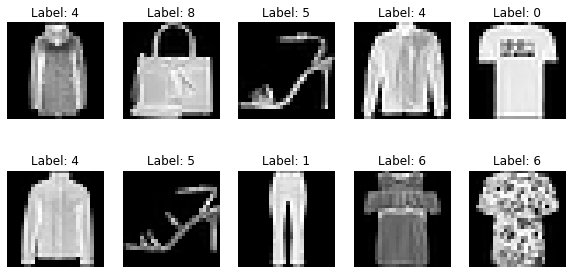

In [8]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(10, 5))
for i in range(10):
    random_num = np.random.randint(0, 59999)
    ax[i//5][i%5].imshow(X_train[random_num].reshape(28, 28), cmap='gray')
    ax[i//5][i%5].set_title(f'Label: {y_train[random_num]}')
    ax[i//5][i%5].axis("off")
plt.show()

Для спрощення, завантажимо fashion mnist з бібліотеки tensorflow за допомогою tf.datasets

In [165]:
import tensorflow as tf
import tensorflow_datasets as tfds


train_data, val_data, test_data = tfds.load("mnist", 
                                            split=['train[10000:]', 'train[0:10000]', 'test'],
                                            batch_size=128, as_supervised=True)

Пронормуємо дані, а також змінимо їх розмірність

In [166]:
def preprocess(X_data, y_data):
    X_data = tf.reshape(X_data, shape=[-1, 784])
    X_data = X_data/255
    
    return X_data, y_data


train_data = train_data.map(preprocess)
val_data = val_data.map(preprocess)

## Створення моделі

реалізуємо базову мережу прямого розповсюдження сигналу. Для цього створимо клас MLP. В ньому будуть такі методи:

1. перегружений метод __call__ обчислює вихід нейронно] мережі
2. predict - працює так як __call__, але використовує ще фунцію softmax
3. forward - на вхід нейронної мережі подається батч і обчислюються значення accuracy та значення функції втрат на виході
4. train - використовуючи метод зворотнього розповсюдження помилки навчає модель

Також змінимо оптимізатор Adam з бібліотеки tensorflow

In [60]:
def loss(y_pred, y):
    sparse_ce = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=y_pred)
    return tf.reduce_mean(sparse_ce)


def accuracy(y_pred, y):
    class_preds = tf.argmax(tf.nn.softmax(y_pred), axis=1)
    is_equal = tf.equal(y, class_preds)
    return tf.reduce_mean(tf.cast(is_equal, tf.float32))

In [94]:
class Layer(tf.Module):

    def __init__(self, out_shape, activation=tf.identity):
        
        self.out_shape = out_shape
        self.activation = activation
        self.built = False

    def __call__(self, x):
        if not self.built:

            self.in_dim = x.shape[1]
            
            w_values = np.random.normal(size=(self.in_dim, self.out_shape), loc = 0, scale = 1)
            
            self.w = tf.Variable(tf.convert_to_tensor(w_values, dtype = tf.float32))
            self.b = tf.Variable(tf.zeros(shape=(self.out_shape,)))
            
            self.built = True
        z = tf.add(tf.matmul(x, self.w), self.b)
        return self.activation(z)
    
    
class MLP(tf.Module):

    def __init__(self, layers):
        self.layers = layers
    
    @tf.function
    def __call__(self, x, preds=False): 
        for layer in self.layers:
            x = layer(x)
        return x
    
    def predict(self, data):
        return tf.nn.softmax(self(data))
        
    def forward(self, x_batch, y_batch, loss, acc, optimizer, batch_type):
        if batch_type == "train":
            with tf.GradientTape() as tape:
                y_pred = self(x_batch)
                batch_loss = loss(y_pred, y_batch)
            batch_acc = acc(y_pred, y_batch)
            grads = tape.gradient(batch_loss, self.variables)
            optimizer.apply_gradients(grads, self.variables)

        else:
            y_pred = self(x_batch)
            batch_loss = loss(y_pred, y_batch)
            batch_acc = acc(y_pred, y_batch)

        return batch_loss, batch_acc
        
        
    
    def train(self, train_data, val_data, loss, acc, optimizer, epochs, PRINT = True):
        train_losses, train_accs = [], []
        val_losses, val_accs = [], []

        for epoch in range(epochs):
            batch_losses_train, batch_accs_train = [], []
            batch_losses_val, batch_accs_val = [], []

            for x_batch, y_batch in train_data:
                batch_loss, batch_acc = self.forward(x_batch, y_batch, loss, acc, optimizer, "train")
                batch_losses_train.append(batch_loss)
                batch_accs_train.append(batch_acc)


            for x_batch, y_batch in val_data:
                batch_loss, batch_acc = self.forward(x_batch, y_batch, loss, acc, optimizer, "val")
                batch_losses_val.append(batch_loss)
                batch_accs_val.append(batch_acc)

            train_loss, train_acc = tf.reduce_mean(batch_losses_train), tf.reduce_mean(batch_accs_train)
            val_loss, val_acc = tf.reduce_mean(batch_losses_val), tf.reduce_mean(batch_accs_val)
            train_losses.append(train_loss)
            train_accs.append(train_acc)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
                
            if PRINT:
                print(f"epoch = {epoch + 1}, train_loss = {train_loss:.4f}, train_acc = {train_acc:.4f} val_loss = {val_loss:.4f}, val_acc = {val_acc:.4f}")
    
        return train_losses, train_accs, val_losses, val_accs
    

    
class Adam:

    def __init__(self, learning_rate=1e-3, beta_1=0.9, beta_2=0.999, ep=1e-7):
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.learning_rate = learning_rate
        self.ep = ep
        self.t = 1.
        self.v_dvar, self.s_dvar = [], []
        self.built = False

    def apply_gradients(self, grads, vars):
        if not self.built:
            for var in vars:
                v = tf.Variable(tf.zeros(shape=var.shape))
                s = tf.Variable(tf.zeros(shape=var.shape))
                self.v_dvar.append(v)
                self.s_dvar.append(s)
            self.built = True
        for i, (d_var, var) in enumerate(zip(grads, vars)):
            self.v_dvar[i].assign(self.beta_1*self.v_dvar[i] + (1-self.beta_1)*d_var)
            self.s_dvar[i].assign(self.beta_2*self.s_dvar[i] + (1-self.beta_2)*tf.square(d_var))
            v_dvar_bc = self.v_dvar[i]/(1-(self.beta_1**self.t))
            s_dvar_bc = self.s_dvar[i]/(1-(self.beta_2**self.t))
            var.assign_sub(self.learning_rate*(v_dvar_bc/(tf.sqrt(s_dvar_bc) + self.ep)))
        self.t += 1.
        return

## Підбір кількості прихованих шарів

Будемо начати моделі з такимим кількостями прихованих шарів: (500, 500), (900, 900), (400, 500, 400). Будемо використовувати 5 епох для навчання

In [111]:
hidden_layer_1_size = 700
hidden_layer_2_size = 500
output_size = 10


layers = [
    [Layer(out_shape=500, activation=tf.nn.relu), Layer(out_shape=500, activation=tf.nn.relu), Layer(out_shape=10)],
    [Layer(out_shape=900, activation=tf.nn.relu), Layer(out_shape=900, activation=tf.nn.relu), Layer(out_shape=10)],
    [Layer(out_shape=400, activation=tf.nn.relu), Layer(out_shape=500, activation=tf.nn.relu), Layer(out_shape=400, activation=tf.nn.relu),  Layer(out_shape=10)]
]

labels = [
    "(500, 500)",
    "(900, 900)",
    "400, 500, 400"
]

info = {}
k = 0 
for layer in layers:
    model = MLP(layer)
    training_info = mlp_model.train(train_data, val_data, loss=loss, acc=accuracy, optimizer=Adam(), epochs=5, PRINT = False)
    info[labels[k]] = training_info 
    k += 1


графіки для моделі (500, 500): 



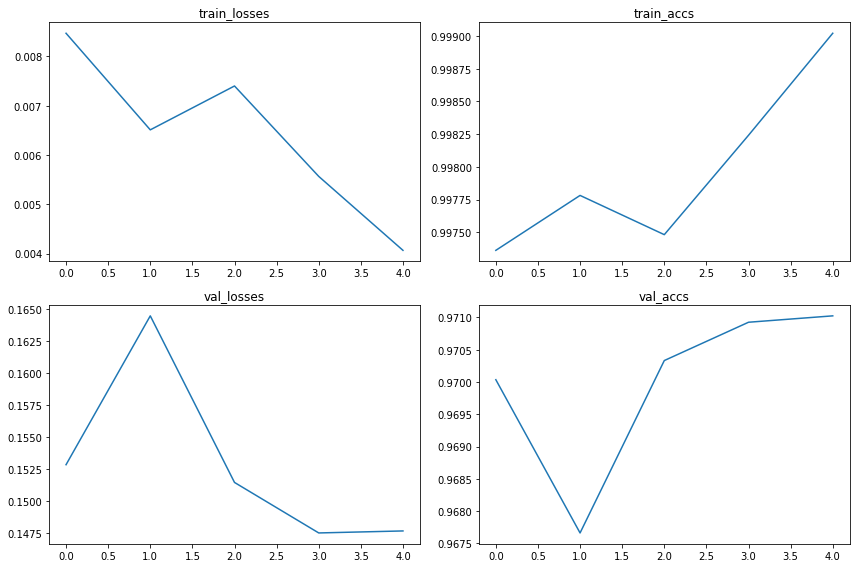


графіки для моделі (900, 900): 



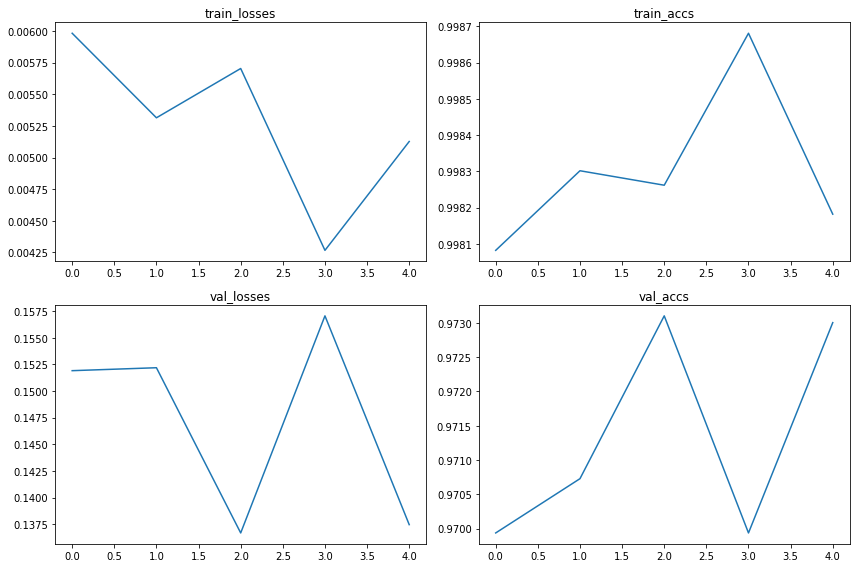


графіки для моделі 400, 500, 400: 



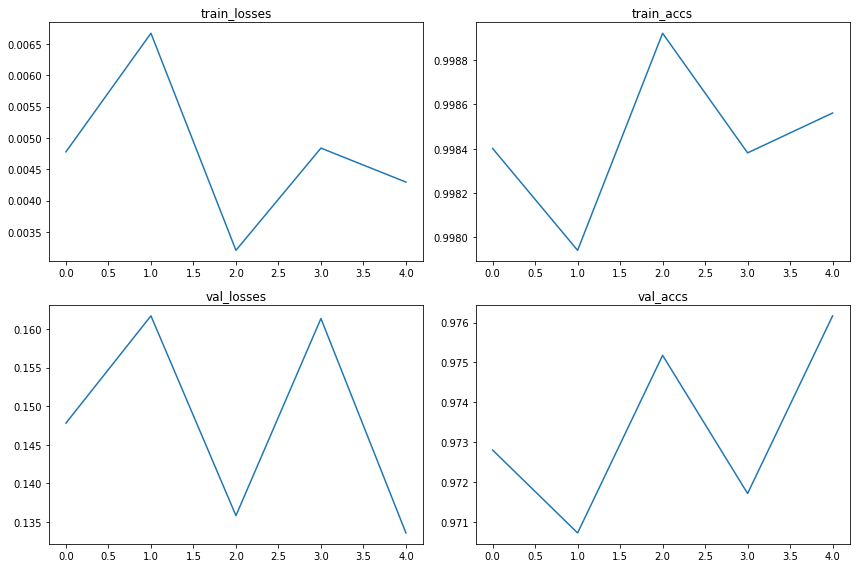

In [112]:
def plot_info(info):
    for key in info.keys():
        train_losses, train_accs, val_losses, val_accs = info[key]
        
        print(f"\nграфіки для моделі {key}: \n")
    
        train_losses = [val.numpy() for val in train_losses]
        train_accs   = [val.numpy() for val in train_accs]
        val_losses   = [val.numpy() for val in val_losses]
        val_accs     = [val.numpy() for val in val_accs]
    
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
    
        # Графік train_losses
        axes[0, 0].plot(train_losses)
        axes[0, 0].set_title('train_losses')

        # Графік train_accs
        axes[0, 1].plot(train_accs)
        axes[0, 1].set_title('train_accs')

        # Графік val_losses
        axes[1, 0].plot(val_losses)
        axes[1, 0].set_title('val_losses')

        # Графік val_accs
        axes[1, 1].plot(val_accs)
        axes[1, 1].set_title('val_accs')

        plt.tight_layout()
        plt.show()


plot_info(info)

Як бачимо, найкращий показник параметру val accuracy дала модель (400, 500, 400).

## Підбір параметру швидкості навчання

будемо вибирати серед таких значень: 1e-5, 1e-4, 1e-3 для найкращої моделі з попереднього пункту


графіки для моделі 1e-5: 



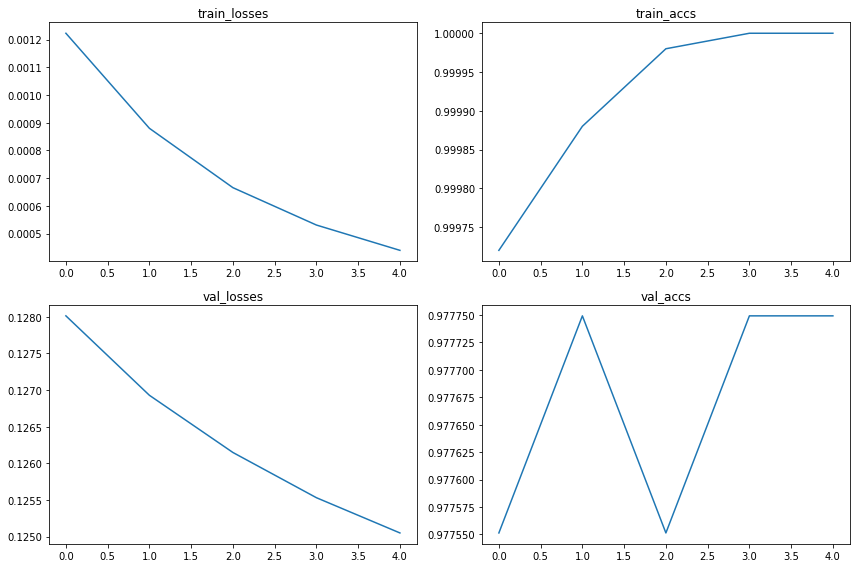


графіки для моделі 1e-4: 



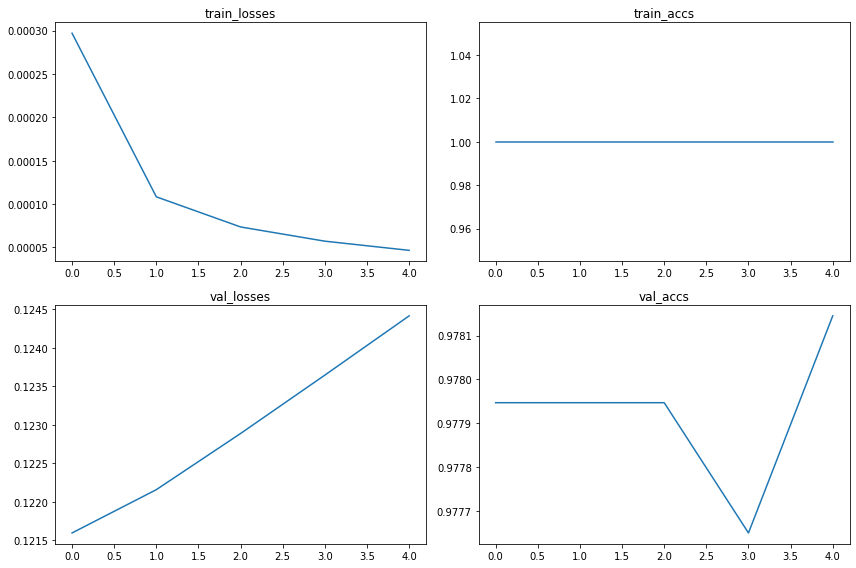


графіки для моделі 1e-3: 



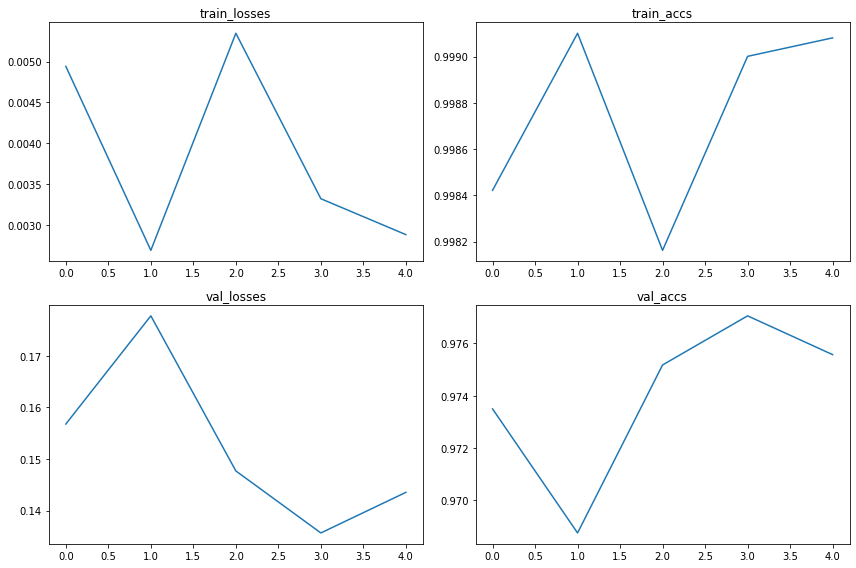

In [114]:
etas = [1e-5, 1e-4, 1e-3]
labels = ["1e-5", "1e-4", "1e-3"]

layers = [Layer(out_shape=400, activation=tf.nn.relu),
          Layer(out_shape=500, activation=tf.nn.relu),
          Layer(out_shape=400, activation=tf.nn.relu),
          Layer(out_shape=10)
]

info = {}
k = 0 
for eta in etas:
    model = MLP(layers)
    training_info = mlp_model.train(train_data, val_data, loss=loss, acc=accuracy, optimizer=Adam(learning_rate = eta), epochs=5, PRINT = False)
    info[labels[k]] = training_info 
    k += 1
    
plot_info(info)

Як бачимо, найкращий показник параметру val accuracy дала модель 1e-4.

## Підбір функції активації 

будемо вибирати серед tanh, sigmoid та relu. Окрім значень метрик розглянемо швидкість навчання моделі 

relu, час навчання: 109.4441
sigmoid, час навчання: 126.5461
tanh, час навчання: 136.793

графіки для моделі relu: 



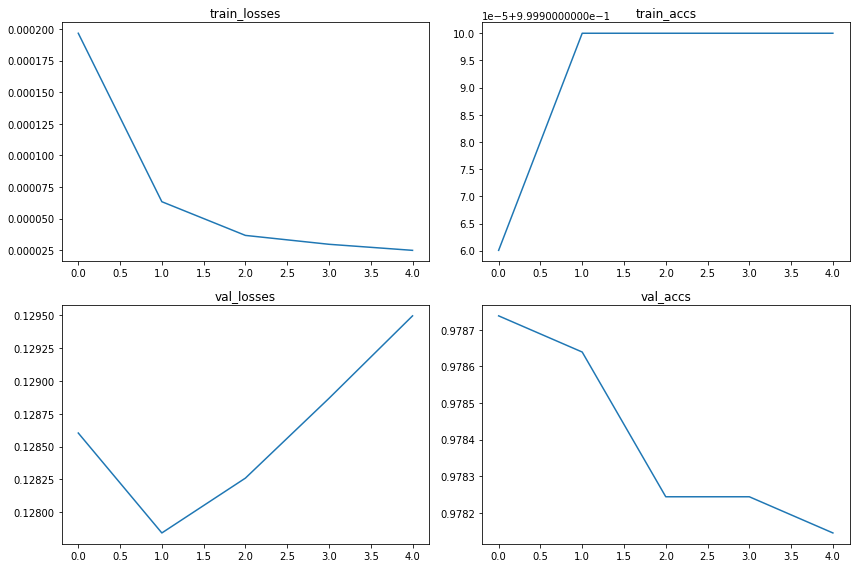


графіки для моделі sigmoid: 



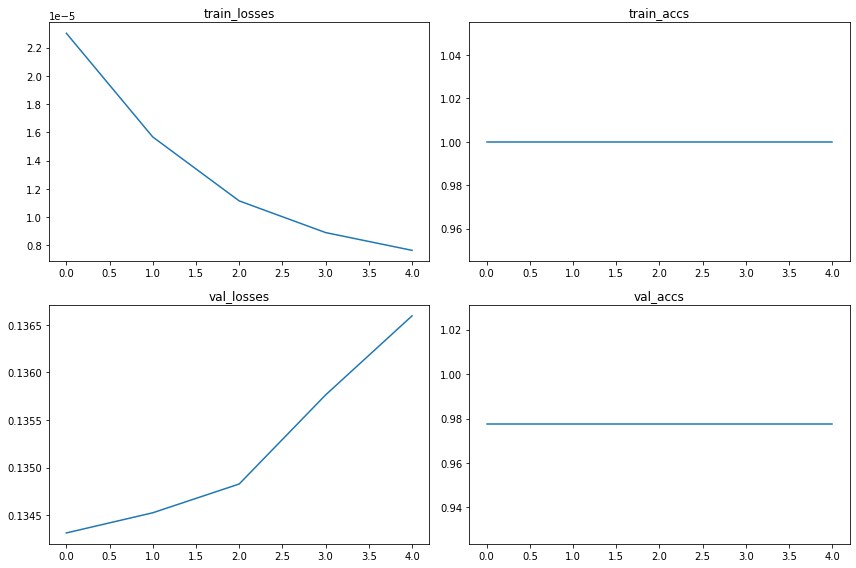


графіки для моделі tanh: 



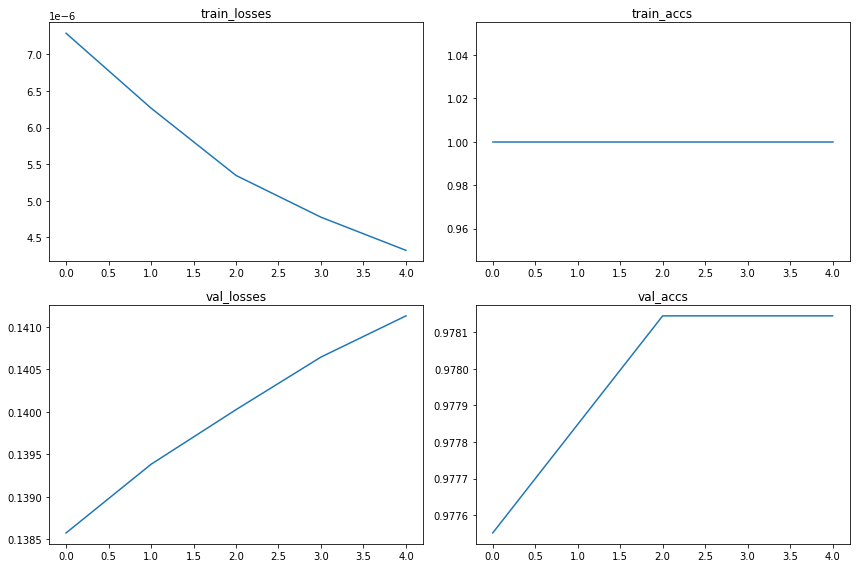

In [116]:
import time 

funcs  = [tf.nn.relu, tf.nn.sigmoid, tf.nn.tanh]
labels = ["relu", "sigmoid", "tanh"]

info = {}
k = 0 
for func in funcs:
    layer = [Layer(out_shape=400, activation=func),
              Layer(out_shape=500, activation=func),
              Layer(out_shape=400, activation=func),
              Layer(out_shape=10)
    ]
    
    model = MLP(layer)
    
    start = time.time()
    training_info = mlp_model.train(train_data, val_data, loss=loss, acc=accuracy, optimizer=Adam(learning_rate = 1e-4), epochs=5, PRINT = False)
    end = time.time()
    
    elapsed_time = end - start
    print(f"{labels[k]}, час навчання: {round(elapsed_time, 4)}")
    info[labels[k]] = training_info 
    k += 1
    
plot_info(info)

Як бачимо, найкраще значення параметру val accuracy дала модель з функцією активації tanh, але при цьому вона найдовше навчалась(приблизно 2 хвилини 16 секунд). Найшвидше навчалась модель з функцією активації relu, але при цьому дала найгірше значення параметру val accuracy.

Отже наша фінальна модель має такі параметри:
- кількість прихованих шарів: (400, 500, 400) 
- швидкість навчання: 1e-4
- функція активації: гіперболічний тангенс

In [167]:
final_layers = [Layer(out_shape=400, activation=tf.nn.tanh),
                Layer(out_shape=500, activation=tf.nn.tanh),
                Layer(out_shape=400, activation=tf.nn.tanh),
                Layer(out_shape=10)
    ]

final_model = MLP(final_layers)
_ = mlp_model.train(train_data, val_data, loss=loss, acc=accuracy, optimizer=Adam(learning_rate = 1e-4), epochs=5)

epoch = 1, train_loss = 1.008, train_acc = 0.998 val_loss = 42.770, val_acc = 0.972
epoch = 2, train_loss = 0.276, train_acc = 0.999 val_loss = 42.137, val_acc = 0.973
epoch = 3, train_loss = 0.063, train_acc = 1.000 val_loss = 41.398, val_acc = 0.974
epoch = 4, train_loss = 0.024, train_acc = 1.000 val_loss = 41.362, val_acc = 0.973
epoch = 5, train_loss = 0.008, train_acc = 1.000 val_loss = 41.359, val_acc = 0.973


# Висновок

У ході даної роботи була реалізована модель MLP. Були проведені деякі дослідження та за допомогою них були знайдені найкращі параметри для моделі. Ними виявились: 
- кількість прихованих шарів: (400, 500, 400) 
- швидкість навчання: 1e-4
- функція активації: гіперболічний тангенс